# Tutorial: creation of a notch list

In this tutorial we will create a StochNotchList object that can be used in pyGWB to apply a notch_mask to your analysis.

The notch-module assumes one already knows which lines should be notched. If this is not the case one should first use other tools to understand which frequencies shouldn't be analysed.

In this tutorial we will assume we have three different detectors: H1, L1 and V1. We will create three different notch lists, one for each baseline HL, HV and LV. We assume the following lines are present:
- H1: callibration line from 16.6Hz to 17.6Hz
- L1: callibration line from 434.4 to 435.4
- V1: callibration line from 16.9Hz to 17.1Hz
- H1, L1: powerlines at 60Hz and harmonics
- V1: powerlines at 50Hz and harmonics
- all baselines : pulsar injections (see data file in input) 
- HV-baseline: a comb of lines at 1Hz and multiples (up to 500Hz), width of 0.01 Hz.

Note: We will only consider lines up to 2024Hz.




<b>
    <center>
        ### DISCLAIMER ###
    
        The examples used here are for illustrative purpose and shouldn't be considered as a realy life scenario, although realistic examples are given.
</b>

## Background on different lines that should be notched

### Calibration lines

### Power lines

### 'Pulsar injections'

### Environmental/instrumental lines and baseline specific lines

## Creation of an example notch list

In [21]:
import numpy as np 
from pygwb import notch

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [8]:
def calibration_lines(det):
    notches = notch.StochNotchList([])
    if det == "H1":
        notches.append(notch.StochNotch(16.6, 17.6, "H1 calibration line"))
    if det == "L1":
        notches.append(notch.StochNotch(434.4, 435.4, "L1 calibration line"))
    if det == "V1":
        notches.append(notch.StochNotch(16.9, 17.1, "V1 calibration line"))
    return notches

In [12]:
noise_power_lines_60 = notch.power_lines(nharmonics=np.ceil(2024./60.))
noise_power_lines_50 = notch.power_lines(fundamental=50, nharmonics=np.ceil(2024./50.))
noise_calibration_lines_H1 = calibration_lines(det="H1")
noise_calibration_lines_L1 = calibration_lines(det="L1")
noise_calibration_lines_V1 = calibration_lines(det="V1")
noise_pulsar_injections = notch.pulsar_injections("Input/Toy_example_pulsars.dat", t_start=1238112018, t_end=1269363618)


noise_lines_HL = notch.StochNotchList([])
noise_lines_HL.extend(noise_power_lines_60)
noise_lines_HL.extend(noise_calibration_lines_H1)
noise_lines_HL.extend(noise_calibration_lines_L1)
noise_lines_HL.extend(noise_pulsar_injections)
noise_lines_HL.save_to_txt('Output/Toy_example_HL_notchlist.txt')

noise_lines_HV = notch.StochNotchList([])
noise_lines_HV.extend(noise_power_lines_60)
noise_lines_HV.extend(noise_power_lines_50)
noise_lines_HV.extend(noise_calibration_lines_H1)
noise_lines_HV.extend(noise_calibration_lines_V1)
noise_lines_HV.extend(noise_pulsar_injections)
noise_lines_HV.extend(notch.comb(1, 1, 500, 0.01))
noise_lines_HV.save_to_txt('Output/Toy_example_HV_notchlist.txt')


noise_lines_LV = notch.StochNotchList([])
noise_lines_LV.extend(noise_power_lines_60)
noise_lines_LV.extend(noise_power_lines_50)
noise_lines_LV.extend(noise_calibration_lines_L1)
noise_lines_LV.extend(noise_calibration_lines_V1)
noise_lines_LV.extend(noise_pulsar_injections)
noise_lines_LV.save_to_txt('Output/Toy_example_LV_notchlist.txt')


With the code above you have created three different notch lists. You have also written their output to a txt file so you can use them at a later time.
In the next step we will use these created notch lists and show how you can apply them in an analysis.

## Applying a notch list

Here we will only use the HL baseline as an example how one can apply a notch list to a (fake) dataset.
Although we can just use the notchlist defined earlier we will read in the notchlist from its text-file to demonstrate this functionality.

In [40]:
HL_notch_list = notch.StochNotchList([])
HL_notch_list = HL_notch_list.load_from_file('Output/Toy_example_HL_notchlist.txt')

We will use the aLIGO design sensitivity curve as our data, which can be downloaded from here: https://dcc.ligo.org/LIGO-T1800044/public
The file included in the 'Input' directory is the fifth version (v5).

Afterwards we will choose to only perfrom our analysis in teh frequency region from 20Hz to 1012Hz with a 1/32Hz (0.03125Hz) resolution.
Note: we strongly advice to always use powers of two as bin width, otherwise your frequencies might not be represented exactely do to non-exact representation in binary.

In [22]:
f = np.arange(20, 1012, 0.03125)
f2,ht2 = np.loadtxt('Input/aLIGOdesign.txt',usecols=(0,1),unpack=True)
ht = np.interp(f, f2, ht2)[:np.size(f)]

In [41]:
HL_notch_mask = HL_notch_list.get_notch_mask(f)
ht_notched = ht * HL_notch_mask

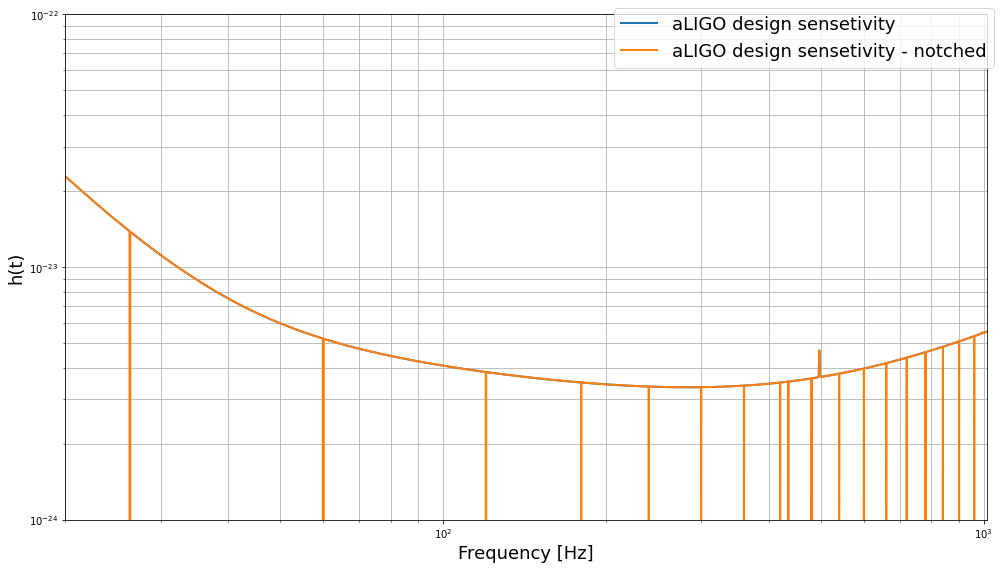

In [47]:
fig, axs = plt.subplots(1,1,figsize=(14,8))
axs.plot(f,ht,label='aLIGO design sensetivity', linewidth = 2)
axs.plot(f,ht_notched,label='aLIGO design sensetivity - notched', linewidth = 2)
plt.ylabel('h(t)',fontsize=18)
plt.xlabel('Frequency [Hz]',fontsize=18) 
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(20,1012)
axs.set_ylim(1e-24,1e-22)
fig.legend(fontsize=18)
plt.grid(True, which="both", ls="-")
fig.tight_layout()

Add some more text describing the notebook.